<div align="center">
    <img src="https://www.sharif.ir/documents/20124/0/logo-fa-IR.png/4d9b72bc-494b-ed5a-d3bb-e7dfd319aec8?t=1609608338755" alt="Logo" width="200">
    <p><b>HW1 @ Deep Learning Course, Dr. Soleymani</b></p>
    <p><b>ِDesinged by Amirmahdi Meighani</b></p>
</div>

---




*Full Name:* Reza Ghorbani Paji

*Student Number:* 403206565

# Efficient Gradient Checkpointing for Memory-Constrained Deep Learning (50 points)
Deep learning experiments are often limited by GPU memory constraints, making it challenging to train large models. To overcome this, we implemented gradient checkpointing, a technique that significantly reduces memory usage by strategically storing intermediate activations and recomputing them during backpropagation. This allows us to train models that would otherwise exceed our GPU’s memory capacity.

In this guide, you'll first implement gradient checkpointing from scratch to understand its inner workings. Then, you'll learn how to leverage PyTorch's built-in checkpointing feature for more efficient deep learning workflows.

### How Gradient Checkpointing Works
We divide the neural network into segments and only store activations at the segment boundaries (checkpoints). The activations for intermediate layers are discarded and recomputed during backpropagation.

Step-by-Step Process:



*   **Forward Pass (Training Phase)**



1.  Divide the model into segments (e.g., every few layers).
2.  Save activations only at checkpoint layers.
3.  Discard activations of intermediate layers.
4.  Proceed as usual to compute the final output.



*   **Backward Pass (Gradient Calculation)**



1. Recompute missing activations for each segment.
2. Compute gradients using the recomputed activations.
3. Update model parameters with computed gradients.


By recomputing only small segments at a time, we save significant memory while keeping the computational cost manageable.


First import what you need and check your GPU.

In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt


# TODO: Your imports
import tqdm
import gc
# End of TODO


In [65]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}") # You must use cuda for this notebook

# Function to measure GPU memory usage
def get_gpu_memory_usage():
    # Todo: return the gpu memory usage for comparison
    return torch.cuda.memory_allocated(device=device) / (1024 * 1024)
    # End of Todo

Using device: cuda


We have created a small model for using it with and with out lazy gradient. You can change it if you like.

In [ ]:
# Define a model for intensive GPU usage
# You can change it
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.before = nn.Sequential(
            nn.Linear(200*200, 100*100),
            nn.ReLU(),
            nn.Linear(100*100, 100),
            nn.ReLU(),
            nn.Linear(100, 32),
            nn.ReLU()
        )

        self.after = nn.Sequential(
            nn.Linear(32, 3000),
            nn.ReLU(),
            nn.Linear(3000, 100*100),
            nn.ReLU(),
            nn.Linear(100*100, 20*50),
            nn.ReLU(),
            nn.Linear(20*50, 1)
        )



    def forward(self, x):
        bottleneck_out = self.before(x)
        final_out = self.after(bottleneck_out)
        return final_out, bottleneck_out




In [ ]:
def create_dataloader(batch_size=128):
    # Todo: Create synthetic data and return a dataloader
    # The data must be compatible with the model you use
    num_samples = 10000
    input_dim = 200*200
    X = torch.randn(num_samples, input_dim)
    y = torch.randn(num_samples, 1)

    data = torch.utils.data.TensorDataset(X, y)

    dataloader = torch.utils.data.DataLoader(data, batch_size = batch_size, shuffle=True)

    return dataloader
    # End of Todo


In [ ]:

# Training loop
def train_model(use_lazy_grad=False, num_epochs=1):
    dataloader = create_dataloader()
    print('Data is Created')
    model = Model().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    mem_usage = []
    start_time = time.time()

    for epoch in range(num_epochs):
        for batch_x, batch_y in tqdm.tqdm(dataloader):

            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            optimizer.zero_grad()
            batch_x.requires_grad = True  # Track gradients
            final_out, bottleneck_out = model(batch_x)


            if use_lazy_grad:
                # Todo: implement the lazy gradient method, using the bottleneck
                # as the only segmentation. You should compute gradient w.r.t
                # bottleneck output and then backpropagate manually
                bottleneck_out.retain_grad()

                loss = criterion(final_out, batch_y)
                loss.backward(retain_graph=True)

                bottleneck_grad = bottleneck_out.grad

                model.after.zero_grad()
                model.before.zero_grad()

                bottleneck_out.backward(bottleneck_grad)
                # End of Todo

            else:
                # Todo: normal back prop of loss
                loss = criterion(final_out, batch_y)
                loss.backward()
                # End of Todo

            optimizer.step()

            mem_usage.append(get_gpu_memory_usage())

    elapsed_time = time.time() - start_time
    return mem_usage, elapsed_time


In [ ]:
# TODO:
# Run training with and without lazy gradient propagation
# Note that you should empty cache of cuda before, between and after your trainings
# So your results will be valid. Save the mem_usage and elapsed_time of each one
torch.cuda.empty_cache()
gc.collect()
mem_usage_noraml, elapsed_time_normal = train_model(use_lazy_grad=False)

torch.cuda.empty_cache()
gc.collect()
mem_usage_lazy, elapsed_time_lazy = train_model(use_lazy_grad=True)
torch.cuda.empty_cache()
gc.collect()

# End of TODO

Data is Created


100%|██████████| 79/79 [00:16<00:00,  4.68it/s]


Data is Created


100%|██████████| 79/79 [00:21<00:00,  3.74it/s]


254

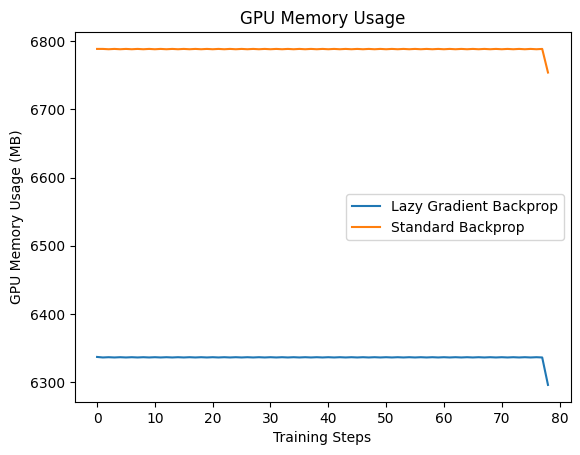

Standard Backprop Time:16.896573781967163
Lazy Gradient Backprop Time:21.133576154708862


In [ ]:
# TODO: Plot memory usage and compare the time
# that each method needs
plt.figure()
plt.plot(mem_usage_lazy, label="Lazy Gradient Backprop")
plt.plot(mem_usage_noraml, label="Standard Backprop")
plt.xlabel("Training Steps")
plt.ylabel("GPU Memory Usage (MB)")
plt.title("GPU Memory Usage")
plt.legend()
plt.show()

print(f'Standard Backprop Time:{elapsed_time_normal}')
print(f'Lazy Gradient Backprop Time:{elapsed_time_lazy}')
# End of TODO

PyTorch provides a built-in gradient checkpointing feature through torch.utils.checkpoint. This makes it easy to implement checkpointing without manually managing activation storage and recomputation.



First, let's create a simple Sequential model and checkpoint it. We can also verify that the checkpointing doesn't change the value of gradients or the activations.

In [ ]:
from torch.utils.checkpoint import checkpoint_sequential


# TODO: create a simple Sequential model and then create the model inputs.
# get the modules in the model. These modules should be in the order
# the model should be executed. Then set the number of checkpoint segments.
# Now call the checkpoint API and get the output.
# finally run the backwards pass on the model. For backwards pass, for simplicity,
# we won't calculate the loss and rather backprop on output.sum()

model = nn.Sequential(
    nn.Linear(128, 50),
    nn.ReLU(),
    nn.Linear(50, 20),
    nn.ReLU(),
    nn.Linear(20, 10)
).to(device)

x = torch.randn(16, 128, requires_grad=True, device=device)

modules = list(model.children())

num_segments = 2

out = checkpoint_sequential(modules, num_segments, x)

out.sum().backward()



# Now we save the output and parameter gradients that we will use for
# comparison purposes with the non-checkpointed run.
output_checkpointed = out.data.clone()
grad_checkpointed = {}
for name, param in model.named_parameters():
    grad_checkpointed[name] = param.grad.data.clone()

Now that we have executed the checkpointed pass on the model, let's also run the non-checkpointed model and verify that the checkpoint API doesn't change the model outputs or the parameter gradients.

In [ ]:
# TODO: use the non-checkpointed mode. create a new variable using the same
# tensor data. get the model output.

model.zero_grad()

x_non_checkpointed = x.clone().detach().requires_grad_(True)

out = model(x_non_checkpointed)

out.sum().backward()


# save the output and parameter gradients values
out_not_checkpointed = out.data.clone()
grad_not_checkpointed = {}
for name, param in model.named_parameters():
    grad_not_checkpointed[name] = param.grad.data.clone()

Now that we have done the checkpointed and non-checkpointed pass of the model and saved the output and parameter gradients, let's compare their values

In [ ]:
# TODO: compare the output and parameters gradients with and without checkpoint.
# they must be equal.

assert torch.allclose(output_checkpointed, out_not_checkpointed, atol=1e-6), "Outputs differ between checkpointed and non-checkpointed runs"

for name in grad_checkpointed:
    assert torch.allclose(grad_checkpointed[name], grad_not_checkpointed[name], atol=1e-6), f"Gradient mismatch for parameter: {name}"

print("All checks passed!")

All checks passed!


So, from this example, we can see that it's very easy to use checkpointing on Sequential models and that the checkpoint API doesn't alter any data. The Checkpoint API implementation is based on autograd and hence there is no need for explicitly specifying what the execution of backwards should look like

# Gradient Accumulation in Deep Learning (25 points)


### 1. Introduction

Training deep learning models with large batch sizes can be difficult due to memory limitations, especially when using large datasets or deep networks. **Gradient Accumulation** is a technique that allows us to simulate large batch sizes without increasing memory usage. This tutorial will cover:

1. **The theory behind Gradient Accumulation**
2. **Using it in PyTorch**
3. **Observing its effects**

---

## 2. Theory Behind Gradient Accumulation

### 2.1 What is Gradient Accumulation?
Instead of updating the model parameters after every mini-batch, **Gradient Accumulation** allows us to accumulate gradients over multiple mini-batches before performing an update. This effectively simulates training with a larger batch size.

### 2.2 Why Use Gradient Accumulation?
- **Overcome Memory Limits**: Training with large batch sizes often exceeds GPU memory capacity. Accumulating gradients allows training on smaller mini-batches while maintaining the benefits of larger batch training.
- **Stable Training**: Larger batch sizes help in stable updates and reducing variance in gradient estimation.
- **Effective Batch Size**: If GPU memory allows batch size `B` but we need `N`, we can accumulate gradients for `N/B` steps before updating.

### 2.3 How Does It Work?
If `loss` is computed on `batch_size = B`, instead of calling `optimizer.step()` every step, we:
1. Compute gradients on `B` and accumulate them.
2. Repeat for `K` iterations, accumulating gradients.
3. Update weights only after `K` steps.
4. Reset gradients after update.

This results in an **effective batch size** of `B * K` without needing extra memory.


first create a simple model and implement the function to train with accumulation.

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_with_gradient_accumulation(model, dataloader, accumulation_steps):
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    model.train()
    optimizer.zero_grad()
    mem_usage = []
    loss = 0

    for batch_idx, (inputs, targets) in enumerate(dataloader):
        # TODO: Get loss and Normalize loss by accumulation steps
        # Then backpropagate loss.  Accumulate gradients and update after
        # `accumulation_steps'
        inputs = inputs.to(device)
        targets = targets.to(device)

        predict = model(inputs)
        loss = criterion(targets, predict) / accumulation_steps
        loss.backward()

        if (batch_idx + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            mem_usage.append(get_gpu_memory_usage())
        # End of TODO


    return mem_usage


class SimpleModel(nn.Module):
    def __init__(self, input_dim=200, hidden_dim=1500, output_dim=1):
        super(SimpleModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.network(x)
# End of TODO


model = SimpleModel().to(device)

Now create a dataloader with the mentioned parameters

In [47]:
def create_dataloader(batch_size, accumulation_steps):

    num_batches = 5
    num_samples = num_batches * batch_size * accumulation_steps

    X = torch.randn(num_samples, 200)

    y = torch.randn(num_samples, 1)

    dataset = torch.utils.data.TensorDataset(X, y)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader


Lets train with accumulation and save mem usage.

In [55]:
batch_size = 100  # Small batch size due to memory limits you can change it
effective_batch_size = 400
accumulation_steps = effective_batch_size // batch_size

# TODO: train with accumulation_steps and save mem_usage
# dont forget to empty cuda cache
torch.cuda.empty_cache()

dataloader = create_dataloader(batch_size, accumulation_steps)

mem_usage_accumulation = train_with_gradient_accumulation(model, dataloader, accumulation_steps)

torch.cuda.empty_cache()



# End of TODO

And now train in the classic way with no accumulation.

In [56]:
# TODO: train with accumulation_steps=1 (it means standard back prop)
# and save mem_usage
torch.cuda.empty_cache()

dataloader_standard = create_dataloader(effective_batch_size, accumulation_steps=1)

mem_usage_standard = train_with_gradient_accumulation(model, dataloader_standard, accumulation_steps=1)

torch.cuda.empty_cache()

# End of TODO

Check if we actually used less memory:

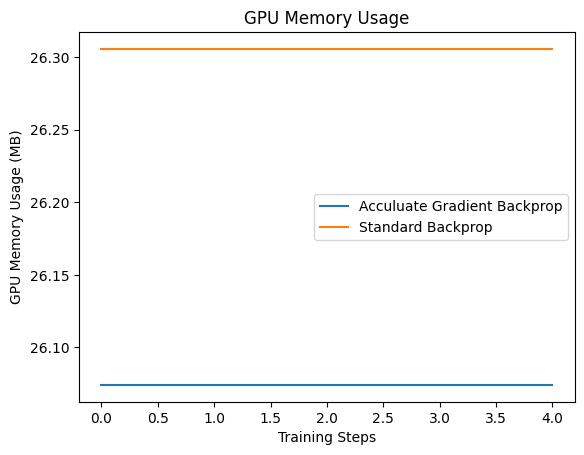

In [57]:
# TODO: Plot memory usage
plt.figure()
plt.plot(mem_usage_accumulation, label="Acculuate Gradient Backprop")
plt.plot(mem_usage_standard, label="Standard Backprop")
plt.xlabel("Training Steps")
plt.ylabel("GPU Memory Usage (MB)")
plt.title("GPU Memory Usage")
plt.legend()
plt.show()

# End of TODO

##  Conclusion

- **Gradient Accumulation** helps simulate large batch sizes without requiring more memory.
- It improves **training stability** and allows training on **memory-constrained GPUs**.
- We implemented it **from scratch** and in **PyTorch**.
- We visualized its **effects** on loss stabilization.

Gradient Accumulation is a useful trick when working with **deep networks and large datasets** on limited hardware. 🚀


# Sources of Randomness (5 points)
run the code below. the outputs are different. Why do you think this happened?

Every time we create a new instance of SimpleModel, its weights and biases are randomly initialized by default. As a result, even if you feed the exact same input to two newly created models, each will produce a different output because the initial parameters diffe

In [ ]:
input = torch.randn(1, 5).to(device)
model = SimpleModel(input_dim=5, hidden_dim=1500,output_dim=1).to(device)

out = model(input)
print(out)

model = SimpleModel(input_dim=5, hidden_dim=1500,output_dim=1).to(device)

out = model(input)
print(out)

tensor([[0.0855]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0551]], device='cuda:0', grad_fn=<AddmmBackward0>)


## Controlling Sources of Randomness in PyTorch Models (with GPU)

### Introduction
Randomness plays a crucial role in deep learning, but uncontrolled randomness can lead to inconsistent results. This part explores the sources of randomness in PyTorch and how to control them, especially when using a GPU.

---

## **1. Understanding Sources of Randomness**
In PyTorch, randomness can come from multiple sources:

1. **Python's built-in random module**: Used for operations that involve randomness in Python code.
2. **NumPy**: If NumPy is used for data augmentation or initialization.
3. **PyTorch CPU Randomness**: Random initialization of weights, dropout layers, etc.
4. **PyTorch GPU Randomness**: When CUDA is used, operations can be non-deterministic.
5. **cuDNN Backend**: NVIDIA's cuDNN has optimizations that may introduce non-determinism.

To get reproducible results, all these sources must be controlled.

## **2. Setting Seeds in PyTorch**
To control randomness, we define a function that sets the seed for all sources:

In [ ]:
import os
import random
import numpy as np
import torch

def set_seed(seed):
    # TODO: set these seeds:
    # Python Hash seed
    # Python random module
    # NumPy seed
    # PyTorch CPU seed
    # PyTorch CUDA seed
    # Multi-GPU seed
    # Ensure deterministic cudnn
    # Disables optimization that may introduce randomness(benchmark)

    os.environ["PYTHONHASHSEED"] = str(seed)

    random.seed(seed)

    np.random.seed(seed)

    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # If using multiple GPUs

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # End of TODO



Now check if the results are the same:

In [ ]:
input = torch.randn(1, 5).to(device)

set_seed(123)  # Set seed to 123 (or any fixed value)
model = SimpleModel(input_dim=5, hidden_dim=1500,output_dim=1).to(device)

out = model(input)
print(out)

set_seed(123)  # Set seed to 123 (or any fixed value)

model = SimpleModel(input_dim=5, hidden_dim=1500,output_dim=1).to(device)

out = model(input)
print(out)

tensor([[0.0854]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.0854]], device='cuda:0', grad_fn=<AddmmBackward0>)


## **Key Takeaways**
1. Randomness in PyTorch comes from multiple sources: Python, NumPy, PyTorch (CPU & GPU), and cuDNN.
2. Using `set_seed()` ensures reproducibility in experiments.
3. cuDNN optimizations can introduce non-determinism; setting `torch.backends.cudnn.deterministic = True` helps mitigate this.
4. Always set the seed before model initialization to ensure identical starting conditions.

Reproducibility is critical for debugging and fair benchmarking of deep learning models. 🚀


**Note**

Setting torch.backends.cudnn.deterministic = True makes the code slower because it forces cuDNN to use deterministic algorithms instead of its default highly-optimized, non-deterministic implementations. Here’s why:
1. cuDNN Optimizations

cuDNN (CUDA Deep Neural Network Library) provides highly optimized implementations of deep learning operations, such as convolutions and matrix multiplications. By default, cuDNN selects the fastest algorithm available based on the given input size, hardware, and configuration.
2. Deterministic vs. Non-Deterministic Algorithms

Some of cuDNN’s fastest algorithms introduce minor sources of randomness due to floating-point precision differences in parallel execution, particularly in:

    Convolution operations (e.g., torch.nn.Conv2d)
    Batch normalization
    Recurrent layers (e.g., LSTMs)

When torch.backends.cudnn.deterministic = True, PyTorch forces cuDNN to use only deterministic versions of these algorithms. However, deterministic algorithms are not always the most optimized ones, leading to slower performance.

# Second-Order Gradients in Deep Learning (20 points)

What are Second-Order Gradients?

In deep learning, second-order gradients refer to the derivatives of gradients (i.e., the second derivative of a loss function with respect to model parameters). These are commonly used in optimization methods that require information about the curvature of the loss function.



### **Mathematically**:
- **First-order gradient**: $ g = \nabla_\theta L(\theta) $ (gradient of loss $ L $ w.r.t. parameters $ \theta $)
- **Second-order gradient (Hessian)**: $ H = \nabla^2_\theta L(\theta) $ (derivative of $ g $, which captures curvature)


###**Why Use Second-Order Gradients?**

 *   Better Optimization – Second-order methods like Newton’s Method use curvature information to converge faster than first-order methods (like SGD).
 *    Natural Gradient Descent – Second-order gradients help in adapting the learning rate in different directions based on the Hessian matrix.
 *   Meta-Learning – Algorithms like MAML (Model-Agnostic Meta-Learning) require second-order gradients to update learning rates.
 *   Adversarial Training – Computing second-order derivatives is useful for generating adversarial examples.
 *   Regularization – Used in some regularization techniques like curvature-based penalties.



###**Challenges of Second-Order Gradients**

 * Computationally Expensive – Computing second-order derivatives (Hessian) can be costly, especially for deep networks.
 * Memory Intensive – Requires additional memory, making it impractical for very large models.
 * Numerical Stability – Sometimes leads to unstable gradients and requires careful tuning.

The second derivative (Hessian matrix) provides information about how the gradient changes. By moving in the direction of the second-order gradient, we can adaptively adjust step sizes based on how steep or flat the loss landscape is.

In the simplest case:

$
θ′=θ−α∇L(θ)−β∇2L(θ)
$

where:

 * ∇2L(θ) (the second-order gradient) adjusts the update based on curvature,
 * β is a small scaling factor.

In [61]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: define a model (1d to 1d)
        self.net = nn.Sequential(
          nn.Linear(1,32),
          nn.ReLU(),
          nn.Linear(32,64),
          nn.ReLU(),
          nn.Linear(64,1)
        )
        # End of TODO

    def forward(self, x):
        # TODO: implement forward
        return self.net(x)
        # End of TODO


def generate_data():
    # TODO: Generate data for 1d to 1d model
    # a simple linear data with noise is ok. For example: y = 2x + 3 + noise
    x = torch.linspace(-5, 5, 100).view(-1, 1)
    noise = torch.randn(x.size()) * 0.5
    y = 2 * x + 3 + noise

    # End of TODO
    return x, y


model = SimpleNet()
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)


x_train, y_train = generate_data()
#x_train, y_train = x_train.to(device), y_train.to(device)
num_epochs = 100

In [62]:

for epoch in range(num_epochs):

    # TODO: implement the loop using second-order gradients.
    # first, compute first-order gradient. Then Convert first-order gradient
    # to scalar before computing second-order gradient Update parameters
    # manually. using first order and second order gradients.
    # print loss in every step

    optimizer.zero_grad()

    y_pred = model(x_train)
    loss = loss_fn(y_pred, y_train)

    grad_1st = torch.autograd.grad(loss, model.parameters(), create_graph=True)

    grad_1st_scalar = sum(torch.sum(g**2) for g in grad_1st)

    grad_2nd = torch.autograd.grad(grad_1st_scalar, model.parameters())

    with torch.no_grad():
        for param, g1, g2 in zip(model.parameters(), grad_1st, grad_2nd):
            param -= 0.01 * (g1 - 0.001 * g2)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")
    # End of TODO


print("Training complete!")


Epoch 1/100, Loss: 37.67866134643555
Epoch 2/100, Loss: 16.182716369628906
Epoch 3/100, Loss: 3.836195468902588
Epoch 4/100, Loss: 2.5614242553710938
Epoch 5/100, Loss: 2.078984022140503
Epoch 6/100, Loss: 1.8747249841690063
Epoch 7/100, Loss: 1.783581256866455
Epoch 8/100, Loss: 1.7180134057998657
Epoch 9/100, Loss: 1.6597453355789185
Epoch 10/100, Loss: 1.6054177284240723
Epoch 11/100, Loss: 1.551411747932434
Epoch 12/100, Loss: 1.4984267950057983
Epoch 13/100, Loss: 1.4443647861480713
Epoch 14/100, Loss: 1.3887603282928467
Epoch 15/100, Loss: 1.3452790975570679
Epoch 16/100, Loss: 1.3031429052352905
Epoch 17/100, Loss: 1.2626041173934937
Epoch 18/100, Loss: 1.2226794958114624
Epoch 19/100, Loss: 1.1839027404785156
Epoch 20/100, Loss: 1.1464781761169434
Epoch 21/100, Loss: 1.1093751192092896
Epoch 22/100, Loss: 1.0735704898834229
Epoch 23/100, Loss: 1.0386180877685547
Epoch 24/100, Loss: 1.0041805505752563
Epoch 25/100, Loss: 0.9709811210632324
Epoch 26/100, Loss: 0.9390498995780945


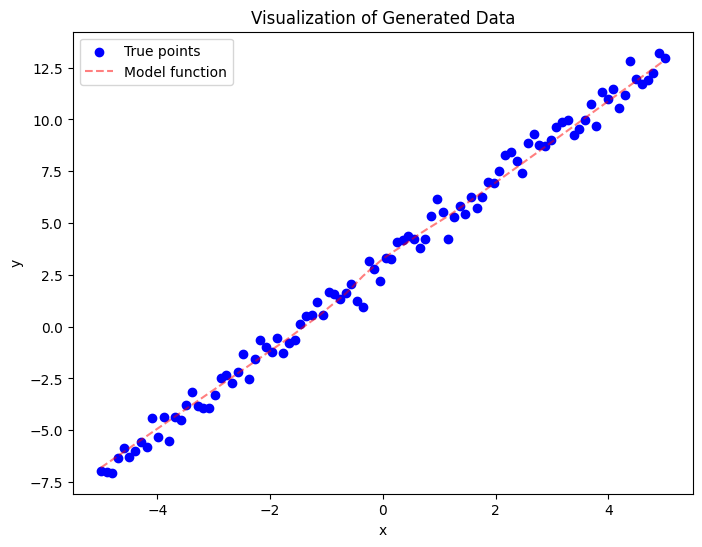

In [63]:
# TODO: evaluate the model using some data and visuilize the model output
# and compare it with the real function

x_test = torch.linspace(-5, 5, 100).view(-1, 1)
noise = torch.randn(x_test.size()) * 0.5
y_real = 2 * x_test + 3 + noise

model.eval()
with torch.no_grad():
    y_pred = model(x_test)

x_test = x_test.cpu()
y_real = y_real.cpu()
y_pred = y_pred.cpu()

plt.figure(figsize=(8, 6))
plt.scatter(x_test, y_real, label="True points", color="blue")
plt.plot(x_test, y_pred, label="Model function", linestyle='--',color="red", alpha=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Visualization of Generated Data")
plt.legend()
plt.show()


# End of TODO

## Interpretation of Moving in the Second-Order Direction

* If the second derivative is large (high curvature) → The loss is changing rapidly → Smaller step sizes.
* If the second derivative is small (low curvature) → The loss changes slowly → Larger step sizes.

This is the core idea behind Newton's method